In [11]:
from sys import argv

import numpy as np
import pandas as pd 
from io_helper import read_tsp, normalize
from neuron import generate_network, get_neighborhood, get_route, get_drone_route
from distance import select_closest, euclidean_distance, route_distance
from plot import plot_network, plot_route
import matplotlib.pyplot as plt
# def main():
#     if len(argv) != 2:
#         print("Correct use: python src/main.py <filename>.tsp")
#         return -1

#     problem = read_tsp(argv[1])

#     route = som(problem, 100000)

#     problem = problem.reindex(route)

#     distance = route_distance(problem)

#     print('Route found of length {}'.format(distance))


In [19]:
points = pd.DataFrame(np.array([[3, 1], [6, 3], [1, 6], [5, 6]]), columns=['x', 'y'])
normalized_points = normalize(points)
normalized_points

# create a network of the following weights
# (0.2,0.76)
# (0.44,0.13)
# (0.21,0.87)
# (0.82,0.1)
# (0.39, 0.2)
# (0.54, 0.11)
# (0.8, 0.54)
# (0.3, 0.22)
network = np.array([[0.2, 0.76], [0.44, 0.13], [0.21, 0.87], [0.82, 0.1], [0.39, 0.2], [0.54, 0.11], [0.8, 0.54], [0.3, 0.22]])
nh_radius = len(network) / 2
n = len(network)
winners = [] 
for i in range(len(normalized_points)):
    node = normalized_points.iloc[i].values
    winner_idx = select_closest(network, node) 
    winners.append(winner_idx)
    print("winner_idx: ", winner_idx)
normalized_points['winner'] = winners
indices = normalized_points.sort_values('winner').index 
print("indices: ", indices)
solution1 = points.reindex(indices)
solution2 = points.reindex([0, 3, 1, 2])
d1 = route_distance(solution1, return_all=True)
d2 = route_distance(solution2,  return_all=True)
print("d1: ", d1)
print("d2: ", d2)

winner_idx:  1
winner_idx:  6
winner_idx:  2
winner_idx:  6
indices:  Int64Index([0, 2, 1, 3], dtype='int64')
d1:  (19.763559169282686, array([5.38516481, 5.38516481, 5.83095189, 3.16227766]))
d2:  (19.763559169282686, array([5.38516481, 5.38516481, 3.16227766, 5.83095189]))


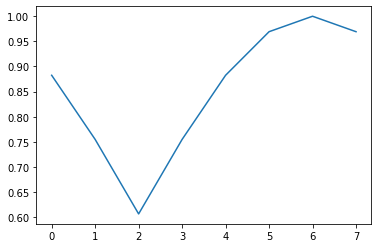

In [12]:
plt.plot(neighbor)

In [27]:
ca_path = '../som_maps/ca4663.tsp'
eg_path = '../som_maps/eg7146.tsp'

it_path = '../som_maps/it16862.tsp'
fi_path = '../som_maps/fi10639.tsp'
mo_path = '../som_maps/mo14185.tsp'
pm_path = '../som_maps/pm8079.tsp'


qa_path = '../som_maps/qa194.tsp'
rw_path = '../som_maps/rw1621.tsp'
uy_path = '../som_maps/uy734.tsp'
zi_path = '../som_maps/zi929.tsp'


small_maps = [qa_path, rw_path, uy_path, zi_path]
small_problems_names = ['qa', 'rw', 'uy', 'zi']
small_problems_num_nodes = [194, 1621, 734, 929]
optimal_distances_for_small_maps = [9352, 26051, 79114, 95345]
small_problems = [read_tsp(path) for path in small_maps]


# ca_problem = read_tsp(ca_path)
# eg_problem = read_tsp(eg_path)
# it_problem = read_tsp(it_path)
# fi_problem = read_tsp(fi_path)
# mo_problem = read_tsp(mo_path)
# pm_problem = read_tsp(pm_path)
# 

Problem with 194 cities read.
Problem with 1621 cities read.
Problem with 734 cities read.
Problem with 929 cities read.


In [28]:
def my_som(problem, iterations, learning_rate=0.8, population_size=8):
    nodes = problem.copy()
    # normalize the nodes coordinates
    nodes[['x', 'y']] = normalize(nodes[['x', 'y']])
    n = nodes.shape[0] * population_size
    network = generate_network(n)

    # learning_rate = 0.8
    learning_rate_decay = 0.99997
    nh_radius = n//10
    nh_radius_decay = 0.9997

    for i in range(iterations):
        # select a random node
        random_node = nodes.sample(1)[['x', 'y']].values

        # find the winner
        winner_idx = select_closest(network, random_node)

        # get the gaussian weighted neighborhood
        gaussian = get_neighborhood(winner_idx, nh_radius, n) 

        # update 
        network += gaussian[:, np.newaxis] * learning_rate * (random_node - network)

        # decay the learning rate and the gaussian radius
        learning_rate = learning_rate * learning_rate_decay
        nh_radius = nh_radius * nh_radius_decay
    plot_network(nodes, network, name = 'mine.png')
    route = get_route(nodes, network)
    return route 


def specific_som(problem, iterations, learning_rate=0.8, population_size=8):
    nodes = problem.copy()
    # normalize the nodes coordinates
    nodes[['x', 'y']] = normalize(nodes[['x', 'y']])
    n = nodes.shape[0] * population_size
    network = generate_network(n)

    iteartions = 100
    # learning_rate = 0.8
    learning_rate_decay = 0.99997
    nh_radius = n//10
    nh_radius_decay = 0.9997

    for i in range(iterations):
        # select a random node
        random_node = nodes.sample(1)[['x', 'y']].values

        # find the winner
        winner_idx = select_closest(network, random_node)

        # get the gaussian weighted neighborhood
        gaussian = get_neighborhood(winner_idx, nh_radius, n) 

        # update 
        network += gaussian[:, np.newaxis] * learning_rate * (random_node - network)

        # decay the learning rate and the gaussian radius
        learning_rate = learning_rate * learning_rate_decay
        nh_radius = nh_radius * nh_radius_decay
        # Check if any parameter has completely decayed.
        if nh_radius < 1:
            print('Radius has completely decayed, finishing execution',
            'at {} iterations'.format(i))
            break
        if learning_rate < 0.001:
            print('Learning rate has completely decayed, finishing execution',
            'at {} iterations'.format(i))
            break
    plot_network(nodes, network, name = 'mine.png')
    route = get_drone_route(nodes, network) # starts from the first node ending at the start node
    # reversing the route
    reversed_route = route[::-1]
    # removing the last node
    reversed_route = reversed_route[:-1]
    concat_route = np.concatenate((route, reversed_route))
    
    return concat_route 



In [29]:
# time 
import time
# problems = [it_problem, fi_problem, mo_problem, pm_problem]
# problem_names = ['Italy', 'Finland', 'Moldova', 'Panama']


iterationss = [100, 1_000, 10_000]
drone_results = pd.DataFrame(columns=['problem', 'iterations', 'time', 'drone_time', 'distance', 'drone_distance', 'quality'])
j = 0
for i in range(len(small_problems)):
    for iterations in iterationss:
        start = time.time()
        route = my_som(small_problems[i], iterations)
        end = time.time()
        start2 = time.time()
        drone_route = specific_som(small_problems[i], iterations)
        end2 = time.time()

        solution = small_problems[i].reindex(route)
        distance = route_distance(solution)

        drone_solution = small_problems[i].reindex(drone_route)
        drone_distance = route_distance(drone_solution)
        
        quality = distance / optimal_distances_for_small_maps[i]
        drone_results.loc[j] = [small_problems_names[i], iterations, end-start, end2-start2, distance, drone_distance, quality]
        j += 1


In [30]:
drone_results

,problem,iterations,time,drone_time,distance,drone_distance,quality
0,qa,100,0.209598,0.165998,20266.008410,41527.646255,2.167024
1,qa,1000,0.490320,0.486135,15435.306727,33891.062443,1.650482
2,qa,10000,3.695309,3.899805,9967.666904,18636.538550,1.065833
3,rw,100,0.648254,0.645385,131294.460796,287472.897092,5.039901
4,rw,1000,1.431163,1.386090,123616.816434,259286.170330,4.745185
5,rw,10000,8.884618,8.685533,38039.480213,74860.413129,1.460193
6,uy,100,0.281530,0.286915,364385.296065,796221.777341,4.605826
7,uy,1000,0.742609,0.743067,348757.369505,660954.719043,4.408289
8,uy,10000,5.543879,5.437883,104557.780601,206684.168970,1.321609
9,zi,100,0.338330,0.344191,441386.247194,808780.802135,4.629359


In [22]:
sample_problem = eg_problem 
route = my_som(sample_problem, 1000)
drone_route = specific_som(sample_problem, 1000)

solution = sample_problem.reindex(route)
drone_solution = sample_problem.reindex(drone_route)

distance, ind_distances = route_distance(solution, return_all = True) 
drone_distance, drone_ind_distances = route_distance(drone_solution, return_all = True) 

route.shape , drone_route.shape, distance, drone_distance

((7146,), (14288,), 2619938.9217617796, 3746764.1734741866)

In [9]:
orig_sol = qa_problem.reindex(qa_route)
drone_sol = qa_problem.reindex(qa_route2)

orig_sol.shape,    drone_sol.shape

((194, 3), (386, 3))

In [10]:
orig_distance = route_distance(orig_sol)
drone_distance = route_distance(drone_sol)
orig_distance, drone_distance

(9972.728916793381, 19070.68764821045)